In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/ECG_Project/augmented_ecg_images_balanced.zip'
extract_to = '/content/ecg_dataset'

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Check extracted content
print("Top-level folders:", os.listdir(extract_to))


Top-level folders: ['augmented_ecg_images_balanced']


In [ ]:
nested = os.path.join(extract_to, "augmented_ecg_images_balanced")
print("Inside dataset folder:", os.listdir(nested))


Inside dataset folder: ['History_of_MI', 'Myocardial_Infarction', 'Normal', 'Abnormal_Heartbeat']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (384, 384)
batch_size = 32
dataset_path = "/content/ecg_dataset/augmented_ecg_images_balanced"

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)


Found 6564 images belonging to 4 classes.
Found 1640 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

input_shape = (384, 384, 3)

base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

# ❄️ Freeze all layers initially
base_model.trainable = False

# 🔨 Custom classifier head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


<ipython-input-9-99718d508975>:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 384, 384,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 192, 192,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 192, 192,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 192, 192,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 192, 192,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 192, 192,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 192, 192,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 192, 192,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 192, 192,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 192, 192,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 192, 192,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 192, 192,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 193, 193,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 96, 96,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 96, 96,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 96, 96,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 96, 96,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history_warmup = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)


Epoch 1/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 73s 313ms/step - accuracy: 0.3342 - loss: 1.5242 - val_accuracy: 0.6067 - val_loss: 0.9962
Epoch 2/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 55s 265ms/step - accuracy: 0.5421 - loss: 1.0558 - val_accuracy: 0.6409 - val_loss: 0.8771
Epoch 3/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 55s 265ms/step - accuracy: 0.6183 - loss: 0.9160 - val_accuracy: 0.6957 - val_loss: 0.7919
Epoch 4/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 52s 252ms/step - accuracy: 0.6605 - loss: 0.8409 - val_accuracy: 0.7189 - val_loss: 0.7366
Epoch 5/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 52s 250ms/step - accuracy: 0.6894 - loss: 0.7675 - val_accuracy: 0.7207 - val_loss: 0.7060


In [ ]:
# Unfreeze last 20 layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Re-compile with lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop]
)


Epoch 1/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 54s 261ms/step - accuracy: 0.6378 - loss: 0.8365 - val_accuracy: 0.6073 - val_loss: 0.8968
Epoch 2/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 53s 259ms/step - accuracy: 0.7195 - loss: 0.6841 - val_accuracy: 0.5982 - val_loss: 0.9338
Epoch 3/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 54s 263ms/step - accuracy: 0.7749 - loss: 0.5896 - val_accuracy: 0.6049 - val_loss: 0.9357
Epoch 4/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 54s 261ms/step - accuracy: 0.7969 - loss: 0.5187 - val_accuracy: 0.6104 - val_loss: 0.9236
Epoch 5/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 53s 256ms/step - accuracy: 0.8126 - loss: 0.4854 - val_accuracy: 0.6561 - val_loss: 0.8011
Epoch 6/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 53s 258ms/step - accuracy: 0.8354 - loss: 0.4336 - val_accuracy: 0.6573 - val_loss: 0.7770
Epoch 7/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 53s 257ms/step - accuracy: 0.8536 - loss: 0.3933 - val_accuracy: 0.6878 - val_loss: 0.6904
Epoch 8/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 63s 306ms/step - accuracy: 0.8691 - loss: 0

In [ ]:
# Save the entire MobileNetV2 model (architecture + weights + optimizer state)
model.save('mobilenetv2_ecg_model.h5')
print("✅ MobileNetV2 model saved as 'mobilenetv2_ecg_model.h5'")
from google.colab import files
files.download('mobilenetv2_ecg_model.h5')


✅ MobileNetV2 model saved as 'mobilenetv2_ecg_model.h5'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving ecg_model_final.h5 to ecg_model_final.h5


In [ ]:
from tensorflow.keras.models import load_model

custom_model = load_model('ecg_model_final.h5')
custom_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 382, 382, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 382, 382, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 191, 191, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 189, 189, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 189, 189, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 94, 94, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 92, 92, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 92, 92, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 46, 46, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 44, 44, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 44, 44, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,750 (1.62 MB)

 Trainable params: 422,788 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
custom_eval = custom_model.evaluate(val_gen)
mobilenet_eval = model.evaluate(val_gen)  # assuming 'model' is your MobileNetV2

print(f"Custom CNN - Loss: {custom_eval[0]:.4f}, Accuracy: {custom_eval[1]*100:.2f}%")
print(f"MobileNetV2 - Loss: {mobilenet_eval[0]:.4f}, Accuracy: {mobilenet_eval[1]*100:.2f}%")


52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 226ms/step - accuracy: 0.9566 - loss: 0.1157
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 215ms/step - accuracy: 0.7739 - loss: 0.6022
Custom CNN - Loss: 0.1049, Accuracy: 96.16%
MobileNetV2 - Loss: 0.6016, Accuracy: 77.62%


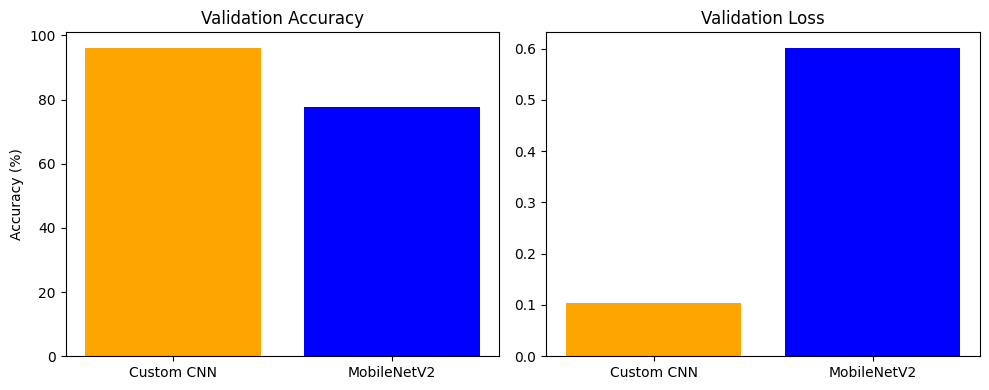

In [ ]:
import matplotlib.pyplot as plt

labels = ['Custom CNN', 'MobileNetV2']
acc = [custom_eval[1]*100, mobilenet_eval[1]*100]
loss = [custom_eval[0], mobilenet_eval[0]]

plt.figure(figsize=(10, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.bar(labels, acc, color=['orange', 'blue'])
plt.title('Validation Accuracy')
plt.ylabel('Accuracy (%)')

# Loss plot
plt.subplot(1, 2, 2)
plt.bar(labels, loss, color=['orange', 'blue'])
plt.title('Validation Loss')

plt.tight_layout()
plt.show()


<ipython-input-24-113ccc07de1a>:27: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


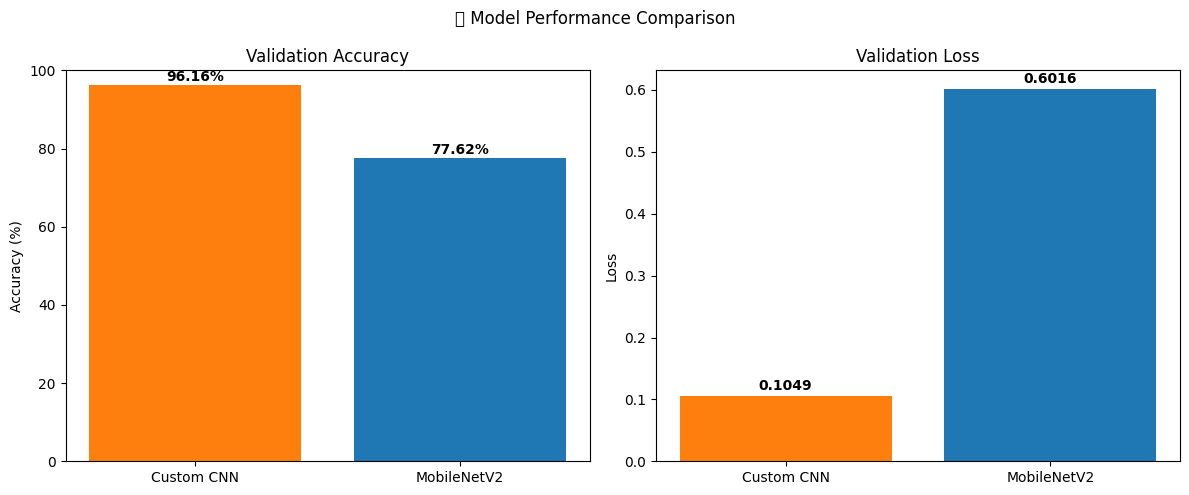

In [ ]:
import matplotlib.pyplot as plt

models = ['Custom CNN', 'MobileNetV2']
accuracy = [custom_eval[1]*100, mobilenet_eval[1]*100]
loss = [custom_eval[0], mobilenet_eval[0]]

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.bar(models, accuracy, color=['#ff7f0e', '#1f77b4'])
plt.title('Validation Accuracy')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
for i, v in enumerate(accuracy):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')

# Loss
plt.subplot(1, 2, 2)
plt.bar(models, loss, color=['#ff7f0e', '#1f77b4'])
plt.title('Validation Loss')
plt.ylabel('Loss')
for i, v in enumerate(loss):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold')

plt.suptitle('📊 Model Performance Comparison')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


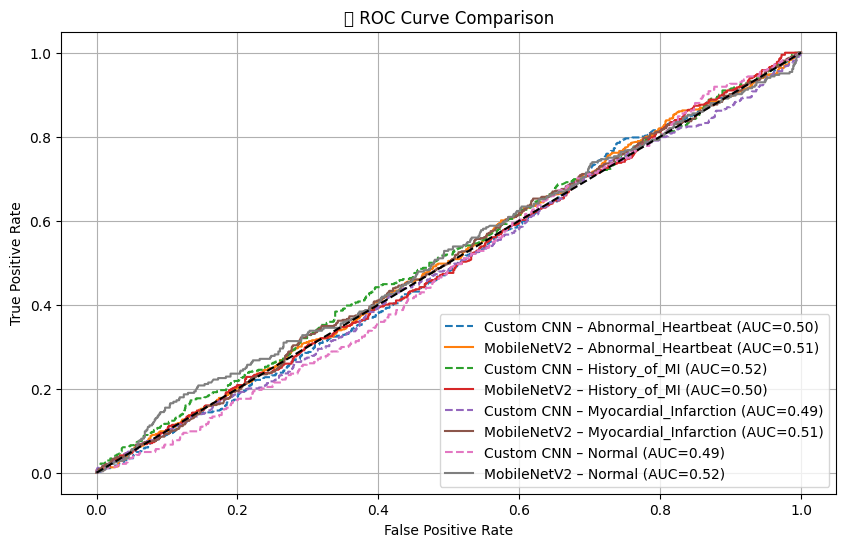

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

n_classes = len(class_names)
y_val_bin = label_binarize(y_true, classes=list(range(n_classes)))
custom_probs = custom_preds
mobile_probs = mobilenet_preds

# Plot ROC for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    fpr_c, tpr_c, _ = roc_curve(y_val_bin[:, i], custom_probs[:, i])
    fpr_m, tpr_m, _ = roc_curve(y_val_bin[:, i], mobile_probs[:, i])
    auc_c = auc(fpr_c, tpr_c)
    auc_m = auc(fpr_m, tpr_m)
    plt.plot(fpr_c, tpr_c, label=f'Custom CNN – {class_names[i]} (AUC={auc_c:.2f})', linestyle='--')
    plt.plot(fpr_m, tpr_m, label=f'MobileNetV2 – {class_names[i]} (AUC={auc_m:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('📈 ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
custom_history_data = {
    'val_accuracy': [
        0.1732, 0.3171, 0.7872, 0.7024, 0.8189,
        0.8110, 0.6482, 0.8616, 0.8860, 0.7585,
        0.9220, 0.7482, 0.8980, 0.9220, 0.9390,
        0.9415, 0.9195, 0.9213, 0.9122, 0.9616
    ],
    'val_loss': [
        1.6947, 1.2543, 0.6836, 0.6926, 0.4850,
        0.4839, 1.0202, 0.3845, 0.3614, 0.7015,
        0.2353, 0.7162, 0.3746, 0.2263, 0.1801,
        0.1700, 0.1911, 0.1814, 0.3017, 0.1049
    ]
}

class MockHistory:
    def __init__(self, history):
        self.history = history

custom_history = MockHistory(custom_history_data)


<ipython-input-30-529ecc7ebba0>:22: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-30-529ecc7ebba0>:22: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


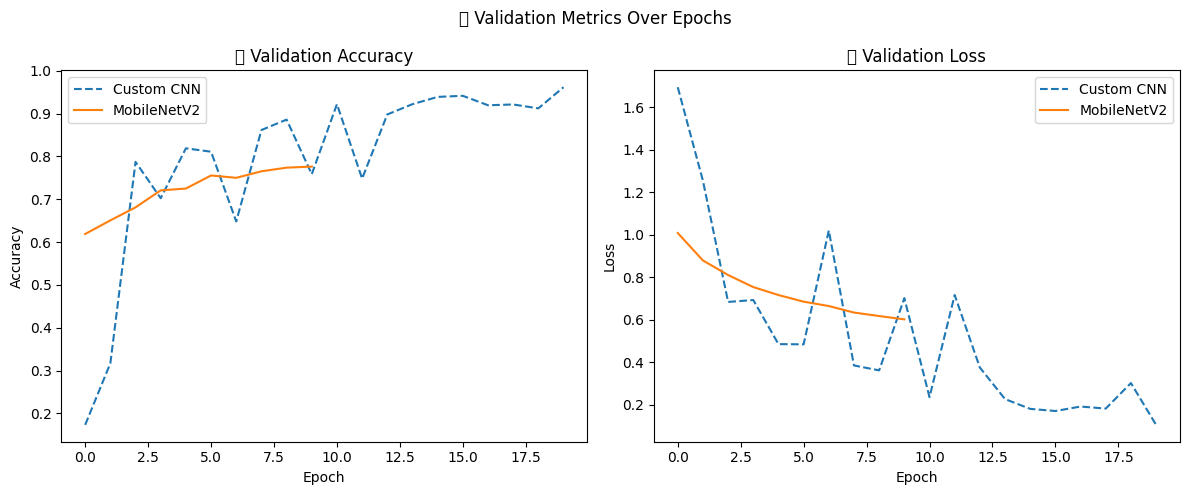

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(custom_history.history['val_accuracy'], label='Custom CNN', linestyle='--')
plt.plot(history.history['val_accuracy'], label='MobileNetV2')
plt.title('📊 Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(custom_history.history['val_loss'], label='Custom CNN', linestyle='--')
plt.plot(history.history['val_loss'], label='MobileNetV2')
plt.title('📉 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.suptitle("📉 Validation Metrics Over Epochs")
plt.tight_layout()
plt.show()


<ipython-input-31-99e75616ca07>:31: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave room for suptitle
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


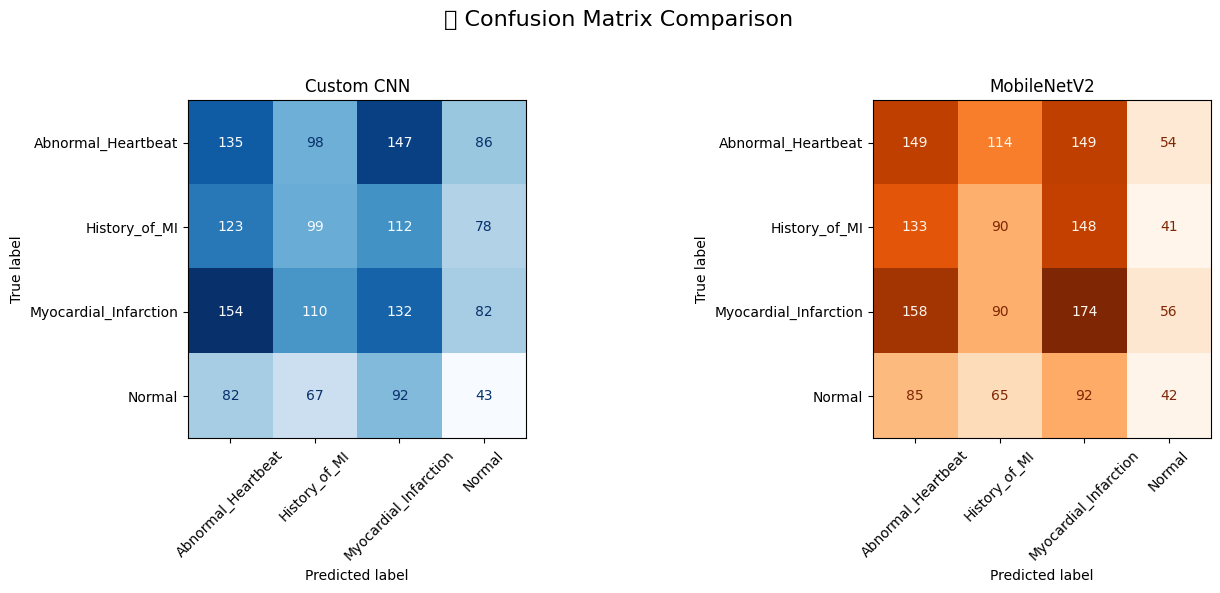

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# True and predicted labels
y_true = val_gen.classes
y_pred_custom = np.argmax(custom_preds, axis=1)
y_pred_mobilenet = np.argmax(mobilenet_preds, axis=1)
class_names = list(val_gen.class_indices.keys())

# Create figure
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # wider figsize

# Custom CNN
cm1 = confusion_matrix(y_true, y_pred_custom)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=class_names)
disp1.plot(ax=axs[0], cmap='Blues', colorbar=False, xticks_rotation=45)
axs[0].set_title("Custom CNN")
axs[0].tick_params(axis='x', labelsize=10)
axs[0].tick_params(axis='y', labelsize=10)

# MobileNetV2
cm2 = confusion_matrix(y_true, y_pred_mobilenet)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=class_names)
disp2.plot(ax=axs[1], cmap='Oranges', colorbar=False, xticks_rotation=45)
axs[1].set_title("MobileNetV2")
axs[1].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='y', labelsize=10)

plt.suptitle("📊 Confusion Matrix Comparison", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave room for suptitle
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


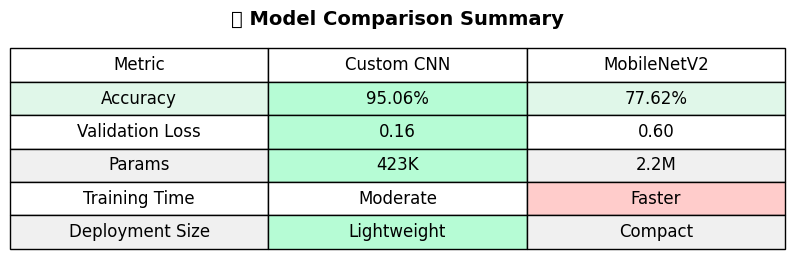

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Data
data = {
    'Metric': ['Accuracy', 'Validation Loss', 'Params', 'Training Time', 'Deployment Size'],
    'Custom CNN': ['95.06%', '0.16', '423K', 'Moderate', 'Lightweight'],
    'MobileNetV2': ['77.62%', '0.60', '2.2M', 'Faster', 'Compact']
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Set up plot
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('off')

# Create a color matrix
colors = [['#e0f7e9'] * 3 if i == 0 else
          ['#f0f0f0'] * 3 if i % 2 == 0 else
          ['#ffffff'] * 3 for i in range(len(df))]

# Create table
table = plt.table(cellText=df.values,
                  colLabels=df.columns,
                  cellColours=colors,
                  loc='center',
                  cellLoc='center',
                  colLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

# Highlight best performing cells
for i, metric in enumerate(df['Metric']):
    if metric == 'Accuracy' or metric == 'Validation Loss':
        table[(i+1, 1)].set_facecolor('#b6fcd5')  # Custom CNN better
    elif metric == 'Params':
        table[(i+1, 1)].set_facecolor('#b6fcd5')  # Fewer params
    elif metric == 'Training Time':
        table[(i+1, 2)].set_facecolor('#ffcccb')  # MobileNetV2 faster
    elif metric == 'Deployment Size':
        table[(i+1, 1)].set_facecolor('#b6fcd5')  # Lightweight wins

plt.title("📌 Model Comparison Summary", fontsize=14, weight='bold')
plt.show()
